In [1]:
import os
import sys
import json
import pyccl
import scipy
import numpy
from itertools import product
from matplotlib import pyplot
import matplotlib.lines as mlines

In [2]:
# Path
TAG = 'Y10'
LABEL = 'CELL'
PATH = '/pscratch/sd/y/yhzhang/LimberCloud'
sys.path.insert(0, os.path.join(PATH, 'PYTHON'))
PLOT_PATH = os.path.join(PATH, 'PLOT', LABEL, TAG)

# Folder
FOLDER = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/LimberCloud/'
PLOT_FOLDER = os.path.join(FOLDER, 'PLOT', LABEL, TAG)
DATA_FOLDER = os.path.join(FOLDER, 'DATA', TAG)
INFO_FOLDER = os.path.join(FOLDER, 'INFO')

In [3]:
# Cosmology
with open(os.path.join(INFO_FOLDER, 'COSMOLOGY.json'), 'r') as file:
    COSMOLOGY_INFO = json.load(file)

COSMOLOGY = pyccl.Cosmology(
    h=COSMOLOGY_INFO['H'],
    w0=COSMOLOGY_INFO['W0'],
    wa=COSMOLOGY_INFO['WA'], 
    n_s=COSMOLOGY_INFO['NS'], 
    A_s=COSMOLOGY_INFO['AS'],
    m_nu=COSMOLOGY_INFO['M_NU'],  
    Neff=COSMOLOGY_INFO['N_EFF'],
    Omega_b=COSMOLOGY_INFO['OMEGA_B'], 
    Omega_k=COSMOLOGY_INFO['OMEGA_K'], 
    Omega_c=COSMOLOGY_INFO['OMEGA_CDM'], 
    mass_split='single', matter_power_spectrum='halofit', transfer_function='boltzmann_camb',
    extra_parameters={'camb': {'kmax': 50, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

pyccl.gsl_params['NZ_NORM_SPLINE_INTEGRATION'] = False
pyccl.gsl_params['LENSING_KERNEL_SPLINE_INTEGRATION'] = False

pyccl.gsl_params['INTEGRATION_GAUSS_KRONROD_POINTS'] = 100
pyccl.gsl_params['INTEGRATION_LIMBER_GAUSS_KRONROD_POINTS'] = 100

In [4]:
# Angular power spectra

def w_m_N(chi_data, chi_grid, phi_m_grid, type):
    data_size = len(chi_data)
    w = numpy.zeros(data_size)
    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind=type)
    for k in range(data_size):
        w[k] = numpy.divide(phi_m(chi_data[k]), chi_data[k], out=numpy.array(0.0), where=chi_data[k] > 0)
    return w

def w_m_S(chi_data, chi_grid, phi_m_grid, redshift_grid, type):
    data_size = len(chi_data)
    w = numpy.zeros(data_size)
    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind=type)
    scale = scipy.interpolate.interp1d(chi_grid, 1 / (1 + redshift_grid), kind=type)
    
    for k in range(data_size):
        def function(chi_prime):
            return phi_m(chi_prime) * (chi_prime - chi_data[k]) / chi_prime
        w[k] = scipy.integrate.fixed_quad(func=function, a=chi_data[k], b=chi_grid.max(), n=100)[0] / scale(chi_data[k])
    return w

def c_a_b_SS(factor, amplitude, phi_a_grid, phi_b_grid, chi_grid, power_grid, redshift_grid, type):
    
    power = scipy.interpolate.interp1d(chi_grid, amplitude * power_grid, kind=type)
    
    def function(chi_data):
        return power(chi_data) * w_m_S(chi_data, chi_grid, phi_a_grid, redshift_grid, type) * w_m_S(chi_data, chi_grid, phi_b_grid, redshift_grid, type)
    
    return factor * scipy.integrate.fixed_quad(func=function, a=chi_grid.min(), b=chi_grid.max(), n=100)[0]

def c_a_b_SN(factor, amplitude, phi_a_grid, phi_b_grid, chi_grid, power_grid, redshift_grid, type):
    
    power = scipy.interpolate.interp1d(chi_grid, amplitude * power_grid, kind=type)
    
    def function(chi_data):
        return power(chi_data) * w_m_S(chi_data, chi_grid, phi_a_grid, redshift_grid, type) * w_m_N(chi_data, chi_grid, phi_b_grid, type)
    
    return factor * scipy.integrate.fixed_quad(func=function, a=chi_grid.min(), b=chi_grid.max(), n=100)[0]

def c_a_b_NS(factor, amplitude, phi_a_grid, phi_b_grid, chi_grid, power_grid, redshift_grid, type):
    
    power = scipy.interpolate.interp1d(chi_grid, amplitude * power_grid, kind=type)
    
    def function(chi_data):
        return power(chi_data) * w_m_N(chi_data, chi_grid, phi_a_grid, type) * w_m_S(chi_data, chi_grid, phi_b_grid, redshift_grid, type)
    
    return factor * scipy.integrate.fixed_quad(func=function, a=chi_grid.min(), b=chi_grid.max(), n=100)[0]

def c_a_b_NN(factor, amplitude, phi_a_grid, phi_b_grid, chi_grid, power_grid, type):
    
    power = scipy.interpolate.interp1d(chi_grid, amplitude * power_grid, kind=type)
    
    def function(chi_data):
        return power(chi_data) * w_m_N(chi_data, chi_grid, phi_a_grid, type) * w_m_N(chi_data, chi_grid, phi_b_grid, type)
    
    return factor * scipy.integrate.fixed_quad(func=function, a=chi_grid.min(), b=chi_grid.max(), n=100)[0]

In [5]:
# Load in Data
LENS = numpy.load(os.path.join(DATA_FOLDER, 'lsst_lens_bins.npy'), allow_pickle=True).item()

# Size
GRID_SIZE = 350
LENS_BIN_SIZE = len(LENS['bins'])
LENS_REDSHIFT = LENS['redshift_range']

# Grid
Z1 = LENS_REDSHIFT.min()
Z2 = LENS_REDSHIFT.max()
Z_GRID = numpy.linspace(Z1, Z2, GRID_SIZE + 1)

LENS_PSI_GRID = numpy.zeros((LENS_BIN_SIZE, GRID_SIZE + 1))
for BIN_INDEX in range(LENS_BIN_SIZE):
    LENS_PSI_GRID[BIN_INDEX, :] = numpy.interp(x=Z_GRID, xp=LENS_REDSHIFT, fp=LENS['bins'][BIN_INDEX])
LENS_PSI_GRID = LENS_PSI_GRID / scipy.integrate.trapezoid(x=Z_GRID, y=LENS_PSI_GRID, axis=1)[:, numpy.newaxis]

# Galaxy
with open(os.path.join(INFO_FOLDER, 'GALAXY.json'), 'r') as file:
    GALAXY_INFO = json.load(file)
GALAXY_BIAS = numpy.array(GALAXY_INFO[TAG])

# Magnification
with open(os.path.join(INFO_FOLDER, 'MAGNIFICATION.json'), 'r') as file:
    MAGNIFICATION_INFO = json.load(file)
MAGNIFICATION_BIAS = numpy.array(MAGNIFICATION_INFO[TAG])

In [6]:
# Phi
A_GRID = 1 / (1 + Z_GRID)
CHI_GRID = pyccl.background.comoving_radial_distance(cosmo=COSMOLOGY, a=A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * COSMOLOGY.h_over_h0(a=A_GRID) * COSMOLOGY_INFO['H'] * 100000 / scipy.constants.c

# Multipole
ELL1 = 20
ELL2 = 2000
ELL_SIZE = 20
ELL_GRID = numpy.geomspace(ELL1, ELL2, ELL_SIZE + 1)
ELL_DATA = numpy.sqrt(ELL_GRID[+1:] * ELL_GRID[:-1])

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_GRID)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out=numpy.zeros((ELL_SIZE + 1, GRID_SIZE + 1)) + numpy.inf, where=CHI_MESH > 0))

# Power
POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE + 1))
for GRID_INDEX in range(GRID_SIZE + 1):
    POWER_GRID[:,GRID_INDEX] = pyccl.power.nonlin_matter_power(cosmo=COSMOLOGY, k=SCALE_GRID[:,GRID_INDEX], a=A_GRID[GRID_INDEX])

# Factor
FACTOR_MM = ELL_GRID ** 2 * (ELL_GRID + 1) ** 2 / (ELL_GRID + 1 / 2) ** 4
FACTOR_MG = ELL_GRID * (ELL_GRID + 1) / (ELL_GRID + 1 / 2) ** 2
FACTOR_GM = ELL_GRID * (ELL_GRID + 1) / (ELL_GRID + 1 / 2) ** 2
FACTOR_GG = numpy.ones(ELL_SIZE + 1)

# Amplitude
AMPLITUDE = 3 / 2 * COSMOLOGY_INFO['OMEGA_M'] * (COSMOLOGY_INFO['H'] * 100000 / scipy.constants.c) ** 2 * numpy.ones((LENS_BIN_SIZE, LENS_BIN_SIZE, GRID_SIZE + 1))
AMPLITUDE_MM = AMPLITUDE ** 2 * (5 * MAGNIFICATION_BIAS[:, numpy.newaxis, numpy.newaxis] - 2) * (5 * MAGNIFICATION_BIAS[numpy.newaxis, :, numpy.newaxis] - 2)
AMPLITUDE_MG = AMPLITUDE * (5 * MAGNIFICATION_BIAS[:, numpy.newaxis, numpy.newaxis] - 2) * GALAXY_BIAS[numpy.newaxis, numpy.newaxis, :]
AMPLITUDE_GM = AMPLITUDE * GALAXY_BIAS[numpy.newaxis, numpy.newaxis, :] * (5 * MAGNIFICATION_BIAS[numpy.newaxis, :, numpy.newaxis] - 2)
AMPLITUDE_GG = GALAXY_BIAS[numpy.newaxis, numpy.newaxis, :] ** 2 * numpy.ones((LENS_BIN_SIZE, LENS_BIN_SIZE, GRID_SIZE + 1))

In [7]:
# C_ELL_TT
C_CCL_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))

C_DATA1_MM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA1_MG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA1_GM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA1_GG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))

C_DATA2_MM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA2_MG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA2_GM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA2_GG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))

C_DATA3_MM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA3_MG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA3_GM = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))
C_DATA3_GG = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE + 1))

for (BIN_INDEX1, BIN_INDEX2) in product(range(LENS_BIN_SIZE), range(LENS_BIN_SIZE)):
    TRACER1 = pyccl.tracers.NumberCountsTracer(cosmo=COSMOLOGY, dndz=[Z_GRID, LENS_PSI_GRID[BIN_INDEX1, :]], bias=[Z_GRID, GALAXY_BIAS], mag_bias=[Z_GRID, MAGNIFICATION_BIAS[BIN_INDEX1] * numpy.ones(GRID_SIZE + 1)], has_rsd=False, n_samples=GRID_SIZE + 1)
    TRACER2 = pyccl.tracers.NumberCountsTracer(cosmo=COSMOLOGY, dndz=[Z_GRID, LENS_PSI_GRID[BIN_INDEX2, :]], bias=[Z_GRID, GALAXY_BIAS], mag_bias=[Z_GRID, MAGNIFICATION_BIAS[BIN_INDEX2] * numpy.ones(GRID_SIZE + 1)], has_rsd=False, n_samples=GRID_SIZE + 1)
    C_CCL_TT[BIN_INDEX1, BIN_INDEX2, :] = pyccl.cells.angular_cl(cosmo=COSMOLOGY, tracer1=TRACER1, tracer2=TRACER2, ell=ELL_DATA, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.001, limber_integration_method='spline', p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    
    for ELL_INDEX in range(ELL_SIZE + 1):
        C_DATA1_MM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SS(factor=FACTOR_MM[ELL_INDEX], amplitude=AMPLITUDE_MM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='slinear')
        C_DATA1_MG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SN(factor=FACTOR_MG[ELL_INDEX], amplitude=AMPLITUDE_MG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='slinear')
        C_DATA1_GM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NS(factor=FACTOR_GM[ELL_INDEX], amplitude=AMPLITUDE_GM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='slinear')
        C_DATA1_GG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NN(factor=FACTOR_GG[ELL_INDEX], amplitude=AMPLITUDE_GG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], type='slinear')
        
        C_DATA2_MM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SS(factor=FACTOR_MM[ELL_INDEX], amplitude=AMPLITUDE_MM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='quadratic')
        C_DATA2_MG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SN(factor=FACTOR_MG[ELL_INDEX], amplitude=AMPLITUDE_MG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='quadratic')
        C_DATA2_GM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NS(factor=FACTOR_GM[ELL_INDEX], amplitude=AMPLITUDE_GM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='quadratic')
        C_DATA2_GG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NN(factor=FACTOR_GG[ELL_INDEX], amplitude=AMPLITUDE_GG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], type='quadratic')
        
        C_DATA3_MM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SS(factor=FACTOR_MM[ELL_INDEX], amplitude=AMPLITUDE_MM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='cubic')
        C_DATA3_MG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_SN(factor=FACTOR_MG[ELL_INDEX], amplitude=AMPLITUDE_MG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='cubic')
        C_DATA3_GM[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NS(factor=FACTOR_GM[ELL_INDEX], amplitude=AMPLITUDE_GM[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], redshift_grid=Z_GRID, type='cubic')
        C_DATA3_GG[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_a_b_NN(factor=FACTOR_GG[ELL_INDEX], amplitude=AMPLITUDE_GG[BIN_INDEX1, BIN_INDEX2, :], phi_a_grid=LENS_PHI_GRID[BIN_INDEX1, :], phi_b_grid=LENS_PHI_GRID[BIN_INDEX2, :], chi_grid=CHI_GRID, power_grid=POWER_GRID[ELL_INDEX, :], type='cubic')

In [8]:
# Projection
from PROJECTION import SS, SN, NS, NN

C_DATA_MM = SS.spectra(
    factor=numpy.array(FACTOR_MM, dtype=numpy.float64), 
    amplitude=numpy.array(AMPLITUDE_MM, dtype=numpy.float64), 
    phi_a_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64), 
    phi_b_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64),
    chi_grid=numpy.array(CHI_GRID, dtype=numpy.float64), 
    power_grid=numpy.array(POWER_GRID, dtype=numpy.float64), 
    redshift_grid=numpy.array(Z_GRID, dtype=numpy.float64)
)

C_DATA_MG = SN.spectra(
    factor=numpy.array(FACTOR_MG, dtype=numpy.float64), 
    amplitude=numpy.array(AMPLITUDE_MG, dtype=numpy.float64), 
    phi_a_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64), 
    phi_b_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64),
    chi_grid=numpy.array(CHI_GRID, dtype=numpy.float64), 
    power_grid=numpy.array(POWER_GRID, dtype=numpy.float64), 
    redshift_grid=numpy.array(Z_GRID, dtype=numpy.float64)
)

C_DATA_GM = NS.spectra(
    factor=numpy.array(FACTOR_GM, dtype=numpy.float64), 
    amplitude=numpy.array(AMPLITUDE_GM, dtype=numpy.float64), 
    phi_a_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64), 
    phi_b_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64),
    chi_grid=numpy.array(CHI_GRID, dtype=numpy.float64), 
    power_grid=numpy.array(POWER_GRID, dtype=numpy.float64), 
    redshift_grid=numpy.array(Z_GRID, dtype=numpy.float64)
)

C_DATA_GG = NN.spectra(
    factor=numpy.array(FACTOR_GG, dtype=numpy.float64), 
    amplitude=numpy.array(AMPLITUDE_GG, dtype=numpy.float64), 
    phi_a_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64), 
    phi_b_grid=numpy.array(LENS_PHI_GRID, dtype=numpy.float64),
    chi_grid=numpy.array(CHI_GRID, dtype=numpy.float64), 
    power_grid=numpy.array(POWER_GRID, dtype=numpy.float64)
)

In [9]:
C_DATA_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))
C_DATA1_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))
C_DATA2_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))
C_DATA3_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))

for (BIN_INDEX1, BIN_INDEX2) in product(range(LENS_BIN_SIZE), range(LENS_BIN_SIZE)):
    C_DATA = C_DATA_MM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA_MG[BIN_INDEX1, BIN_INDEX2, :] + C_DATA_GM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA_GG[BIN_INDEX1, BIN_INDEX2, :]
    C_DATA1 = C_DATA1_MM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA1_MG[BIN_INDEX1, BIN_INDEX2, :] + C_DATA1_GM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA1_GG[BIN_INDEX1, BIN_INDEX2, :]
    C_DATA2 = C_DATA2_MM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA2_MG[BIN_INDEX1, BIN_INDEX2, :] + C_DATA2_GM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA2_GG[BIN_INDEX1, BIN_INDEX2, :]
    C_DATA3 = C_DATA3_MM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA3_MG[BIN_INDEX1, BIN_INDEX2, :] + C_DATA3_GM[BIN_INDEX1, BIN_INDEX2, :] + C_DATA3_GG[BIN_INDEX1, BIN_INDEX2, :]
    
    C_VALUE = scipy.interpolate.CubicSpline(x=numpy.log(ELL_GRID), y=ELL_GRID * C_DATA, bc_type='natural', extrapolate=True)
    C_VALUE1 = scipy.interpolate.CubicSpline(x=numpy.log(ELL_GRID), y=ELL_GRID * C_DATA1, bc_type='natural', extrapolate=True)
    C_VALUE2 = scipy.interpolate.CubicSpline(x=numpy.log(ELL_GRID), y=ELL_GRID * C_DATA2, bc_type='natural', extrapolate=True)
    C_VALUE3 = scipy.interpolate.CubicSpline(x=numpy.log(ELL_GRID), y=ELL_GRID * C_DATA3, bc_type='natural', extrapolate=True)
    
    for ELL_INDEX in range(ELL_SIZE):
        C_DATA_TT[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = C_VALUE.integrate(numpy.log(ELL_GRID[ELL_INDEX]), numpy.log(ELL_GRID[ELL_INDEX + 1])) / (ELL_GRID[ELL_INDEX + 1] - ELL_GRID[ELL_INDEX])
        C_DATA1_TT[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = C_VALUE1.integrate(numpy.log(ELL_GRID[ELL_INDEX]), numpy.log(ELL_GRID[ELL_INDEX + 1])) / (ELL_GRID[ELL_INDEX + 1] - ELL_GRID[ELL_INDEX])
        C_DATA2_TT[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = C_VALUE2.integrate(numpy.log(ELL_GRID[ELL_INDEX]), numpy.log(ELL_GRID[ELL_INDEX + 1])) / (ELL_GRID[ELL_INDEX + 1] - ELL_GRID[ELL_INDEX])
        C_DATA3_TT[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = C_VALUE3.integrate(numpy.log(ELL_GRID[ELL_INDEX]), numpy.log(ELL_GRID[ELL_INDEX + 1])) / (ELL_GRID[ELL_INDEX + 1] - ELL_GRID[ELL_INDEX])

numpy.savetxt(os.path.join(DATA_FOLDER, 'C_CCL_TT.txt'), C_CCL_TT.flatten())
numpy.savetxt(os.path.join(DATA_FOLDER, 'C_DATA_TT.txt'), C_DATA_TT.flatten())
numpy.savetxt(os.path.join(DATA_FOLDER, 'C_DATA1_TT.txt'), C_DATA1_TT.flatten())
numpy.savetxt(os.path.join(DATA_FOLDER, 'C_DATA2_TT.txt'), C_DATA2_TT.flatten())
numpy.savetxt(os.path.join(DATA_FOLDER, 'C_DATA3_TT.txt'), C_DATA3_TT.flatten())

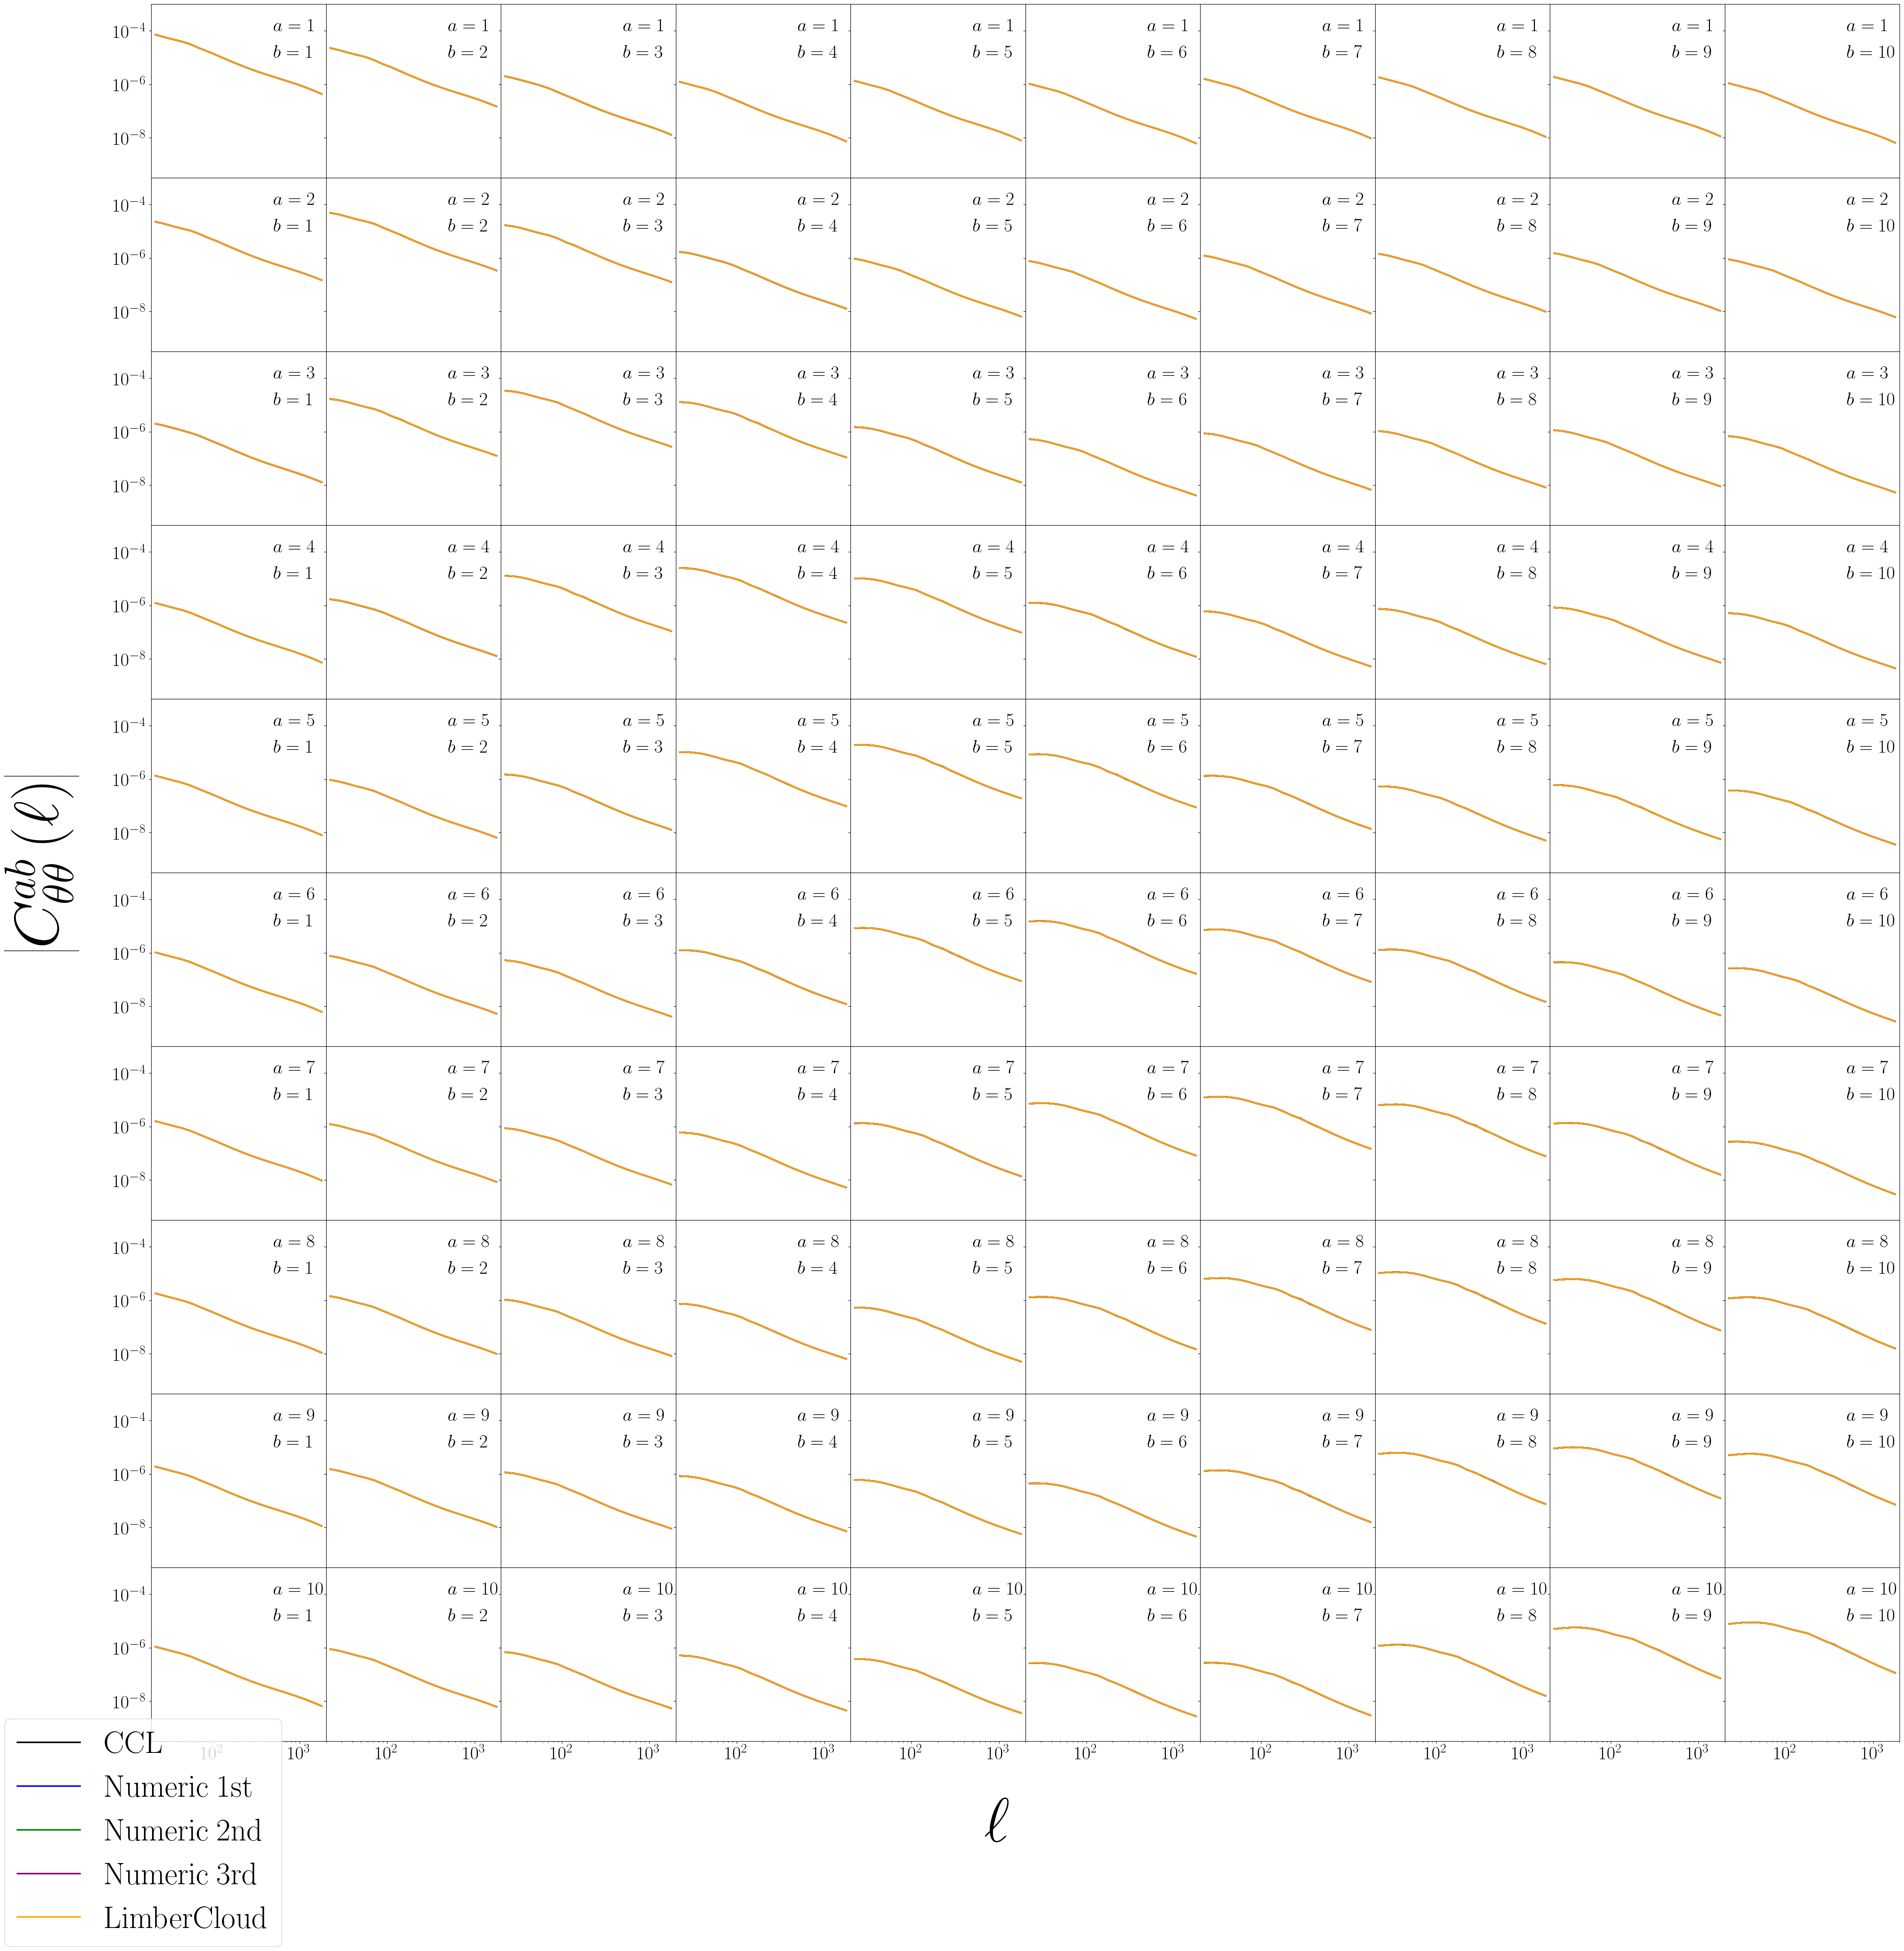

In [10]:
# Figure
os.environ['PATH'] = '/pscratch/sd/y/yhzhang/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']
pyplot.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
pyplot.rcParams['pgf.texsystem'] = 'pdflatex'
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['font.size'] = 30

FIGURE, AXES = pyplot.subplots(nrows=LENS_BIN_SIZE, ncols=LENS_BIN_SIZE, figsize = (LENS_BIN_SIZE * 5, LENS_BIN_SIZE * 5))

for (BIN_INDEX1, BIN_INDEX2) in product(range(LENS_BIN_SIZE), range(LENS_BIN_SIZE)):
    PLOT = AXES[BIN_INDEX1, BIN_INDEX2]
    
    PLOT.plot(ELL_DATA, numpy.abs(C_CCL_TT[BIN_INDEX1, BIN_INDEX2,:]), color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$')
    
    PLOT.plot(ELL_DATA, numpy.abs(C_DATA1_TT[BIN_INDEX1, BIN_INDEX2,:]), color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$')
    
    PLOT.plot(ELL_DATA, numpy.abs(C_DATA2_TT[BIN_INDEX1, BIN_INDEX2,:]), color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$')
    
    PLOT.plot(ELL_DATA, numpy.abs(C_DATA3_TT[BIN_INDEX1, BIN_INDEX2,:]), color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
    
    PLOT.plot(ELL_DATA, numpy.abs(C_DATA_TT[BIN_INDEX1, BIN_INDEX2,:]), color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{LimberCloud}$')
    
    PLOT.text(x = 500, y = 10**-4.0, s = r'$a = {:.0f}$'.format(BIN_INDEX1 + 1))
    PLOT.text(x = 500, y = 10**-5.0, s = r'$b = {:.0f}$'.format(BIN_INDEX2 + 1))
    
    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(ELL1, ELL2)
    PLOT.set_ylim(10**-9.5, 10**-3.0)
    
    if BIN_INDEX1 < LENS_BIN_SIZE - 1: 
        PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: 
        PLOT.set_yticklabels([])

LEGEND = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{LimberCloud}$')
]

FIGURE.legend(
    fontsize=50, 
    handles=LEGEND, 
    loc='upper left', 
    borderaxespad=0.0,
    bbox_to_anchor=(0.06, 0.12)
)

FIGURE.supxlabel(r'$\ell$', fontsize=100, y=0.06)
FIGURE.supylabel(r'$\left| C^{a b}_{\theta \theta} \left(\ell\right) \right|$', fontsize = 100, x=0.06)

FIGURE.subplots_adjust(hspace=0.0, wspace=0.0)
FIGURE.savefig(os.path.join(PLOT_FOLDER, 'CELL_TT.pdf'), bbox_inches='tight')